## PSD estimates feature extraction using MNE library

### Multitaper

In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,f1_score
from sklearn.decomposition import PCA
from spectrum import data_cosine, dpss, pmtm
from mne.time_frequency import psd_array_multitaper


%matplotlib inline 
# %matplotlib qt


In [2]:
# Import datasets, 0.1s samples
T_theta = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/theta/think.pkl")
T_alpha = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/alpha/think.pkl")

C_theta = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/theta/count.pkl")
C_alpha = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.1s/alpha/count.pkl")


In [3]:
def psd_multitaper(df):
    psd_df = df.applymap(lambda x: psd_array_multitaper(x,128,adaptive=True,normalization='full',verbose=0)[0])
    return psd_df 

In [4]:
T_psd_theta = psd_multitaper(T_theta)
T_psd_alpha = psd_multitaper(T_alpha) 

In [5]:
C_psd_theta = psd_multitaper(C_theta)
C_psd_alpha = psd_multitaper(C_alpha) 

In [6]:
print(T_psd_theta.shape)
print(T_psd_alpha.shape)
print(C_psd_theta.shape)
print(C_psd_alpha.shape)

(320, 32)
(320, 32)
(320, 32)
(320, 32)


In [7]:
print(len(T_psd_theta.iloc[0,0]))
print(len(T_psd_alpha.iloc[0,0]))
print(len(C_psd_theta.iloc[0,0]))
print(len(C_psd_alpha.iloc[0,0]))

7
7
7
7


In [8]:
#Expand cells into columns
def expand_PSD_df_list(PSD_df_list):
    e_PSD_df_list = [0]*len(PSD_df_list)
    for df_no in range(len(PSD_df_list)):
        #e_PSD_df_cols_list will be used to create new dataframe
        no_PSD = len(PSD_df_list[0].iloc[0,0])
        e_PSD_df_cols_list = [0]*32
        
        for channel in range(len(PSD_df_list[df_no].columns)):
            #Expand each column into its own dataframe
            new_col = PSD_df_list[df_no][channel].apply(pd.Series)
            #Rename every variable in the new column
            new_col = new_col.rename(columns = lambda x: "Ch"+str(channel+1)+'_'+str(np.linspace(0,64,no_PSD)[x]))
            #Add new_col to cols_list
            e_PSD_df_cols_list[channel] = new_col
        
        #Create new dataframe
        e_PSD_df = pd.concat(e_PSD_df_cols_list, axis=1)
        
        #Add to list
        e_PSD_df_list[df_no] = e_PSD_df
    return e_PSD_df_list     

In [9]:
T_e_psd_theta = expand_PSD_df_list([T_psd_theta])[0]
T_e_psd_alpha = expand_PSD_df_list([T_psd_alpha])[0]
C_e_psd_theta = expand_PSD_df_list([C_psd_theta])[0]
C_e_psd_alpha = expand_PSD_df_list([C_psd_alpha])[0]


In [10]:
#Form datasets 
T_data = np.hstack((T_e_psd_theta,T_e_psd_alpha))
C_data = np.hstack((C_e_psd_theta,C_e_psd_alpha))

print(T_data.shape)
print(C_data.shape)

(320, 448)
(320, 448)


In [11]:
X = np.vstack((T_data,C_data))
y = np.hstack((np.array(['T']*T_data.shape[0]),
               np.array(['C']*C_data.shape[0]),
               ))

X.shape

(640, 448)

In [12]:
#Feature scaling 
sc = StandardScaler()
X = sc.fit_transform(X)
print(X.shape)
print(y.shape)

(640, 448)
(640,)


In [13]:
#Save datasets 
np.save("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/featureScaled/X-features",X,allow_pickle=True)
np.save("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/featureScaled/y-labels",y,allow_pickle=True)

In [21]:
#Split into training and test sets
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index],X[test_index]
    y_train, y_test = y[train_index],y[test_index]

#Fit transform on training data
pca99 = PCA(n_components=0.999, svd_solver='full')
x_99_train = pca99.fit_transform(X_train)
#Fit transform on test data
x_99_test = pca99.transform(X_test)
#Gridsearch
C_range = [1,3,10,30,100,300]
param_grid= [
            # {'C': C_range, 'kernel': ['linear']},
            {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
            ]
scoring = {'accuracy','f1_macro'}
clf = svm.SVC()
grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=10,refit='f1_macro')
grid99 = grid.fit(x_99_train,y_train)
#Best Params
best_params99 = grid99.best_params_
clf99 = svm.SVC(**best_params99)
clf99.fit(x_99_train,y_train)
y_99_pred = clf99.predict(x_99_test)
f1Score = f1_score(y_test,y_99_pred,average="macro")
#Confusion matrix
cm = confusion_matrix(y_test,y_99_pred,normalize='true')

In [22]:
print(f1Score)

0.7417935081606455


In [23]:
print(cm)

[[0.703125 0.296875]
 [0.21875  0.78125 ]]


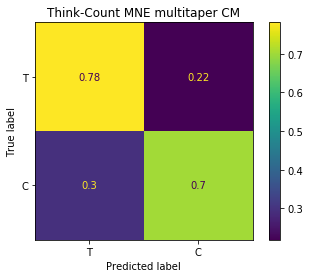

In [24]:
##Confusion matrix
target_names = ['T','C']
fig,ax = plt.subplots()
ax.set_title('Think-Count MNE multitaper CM')
plot_confusion_matrix(clf99,x_99_test,y_test,labels=target_names,ax=ax,normalize='true')
plt.savefig("/media/wubuntu/My Passport/EEG-data/think-count/multitaper/mne/Think-Count_0.1s_CM.png")

In [25]:
# Import raw datasets, 0.05s samples
T_theta_005 = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.05s/theta/think.pkl")
T_alpha_005 = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.05s/alpha/think.pkl")

C_theta_005 = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.05s/theta/count.pkl")
C_alpha_005 = pd.read_pickle("/media/wubuntu/My Passport/EEG-data/think-count/filtered/0.05s/alpha/count.pkl")
